In [1]:
import math, copy, sys, logging, json, time, random, os, string, pickle, re

import torch
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

from modules.TransformerComponents import Transformer
from modules.Vocabulary import Vocab
from modules.MetaLearnNeuralMemory import MNMp
from modules.LoadTrainSave import save_model, load_model

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(0) 
random.seed(0)
torch.manual_seed(0)

print('torch.version', torch.__version__)
print('torch.cuda.is_available()', torch.cuda.is_available())
print('torch.cuda.device_count()', torch.cuda.device_count())

torch.version 1.7.0
torch.cuda.is_available() True
torch.cuda.device_count() 2


In [2]:
class Teacher(): 
    
    def __init__(self, vocab):
        
        self.vocab = vocab

        self.vocab.string2embedding("my name is, hi. what is my name? its")
        
        self.name_list = [
                          'vicki', 'carson', 'melissa', 'salvador', 
                          'force', 'sky', 'zen', 'adam'
                         ]

    def random_name(self,):
        """ Generate a random string of fixed length """
        return random.choice(self.name_list)
    
    def repeat(self, batch_size):
        
        self.mynameis = self.vocab.string2tensor("my name is")
        self.hi = self.vocab.string2tensor("hi")
        self.whatmyname = self.vocab.string2tensor("what is my name?")
        self.its = self.vocab.string2tensor("its")

        self.mynameis = self.mynameis.repeat(batch_size,1)
        self.hi = self.hi.repeat(batch_size,1)
        self.whatmyname = self.whatmyname.repeat(batch_size,1)
        self.its = self.its.repeat(batch_size,1)
    
    def get_batch(self, batch_size):
        
        self.repeat(batch_size)
        
        newnames = ""
        for n in range(batch_size):
            newnames += " " + self.random_name()
            
        self.vocab.string2embedding(newnames)
        
        self.names = self.vocab.string2tensor(newnames).T

        self.intro = torch.cat((self.mynameis, self.names),dim=1)
        self.introtarget = torch.cat((self.hi, self.names),dim=1)
        self.yournameis = torch.cat((self.its, self.names),dim=1)
        
        return self.intro, self.introtarget, self.whatmyname, self.yournameis

In [55]:
vocab = Vocab(emb_dim=32)
teacher = Teacher(vocab)

print(vocab.word2index)

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'my': 4, 'name': 5, 'is': 6, ',': 7, 'hi': 8, '.': 9, 'what': 10, '?': 11, 'its': 12}


In [61]:
batch_size = 4

intro, introtarget, whatmyname, yournameis = teacher.get_batch(batch_size)

print(vocab.word2index)

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'my': 4, 'name': 5, 'is': 6, ',': 7, 'hi': 8, '.': 9, 'what': 10, '?': 11, 'its': 12, 'melissa': 13, 'vicki': 14, 'sky': 15, 'adam': 16}


In [62]:
intro # my name is <new token>

tensor([[ 4,  5,  6, 15],
        [ 4,  5,  6, 15],
        [ 4,  5,  6, 14],
        [ 4,  5,  6, 16]])

In [63]:
introtarget # hi <new token>

tensor([[ 8, 15],
        [ 8, 15],
        [ 8, 14],
        [ 8, 16]])

In [64]:
whatmyname # what is my name ?

tensor([[10,  6,  4,  5, 11],
        [10,  6,  4,  5, 11],
        [10,  6,  4,  5, 11],
        [10,  6,  4,  5, 11]])

In [65]:
yournameis # its <new token>

tensor([[12, 15],
        [12, 15],
        [12, 14],
        [12, 16]])

In [3]:
class Bot(nn.Module):
    
    def __init__(self, emb_dim, n_layers, heads, dropout, vocab):
        
        super().__init__()
        
        self.emb_dim = emb_dim
        
        self.vocab = vocab
        self.sos_tok = torch.LongTensor([[self.vocab.word2index["<SOS>"]]]) 
        self.eos_tok = torch.LongTensor([[self.vocab.word2index["<EOS>"]]]) 
        
        self.encodeInput = Transformer(emb_dim, n_layers, heads, dropout)
        self.encodeEncoding = Transformer(emb_dim, n_layers, heads, dropout)
        self.decodeEncoding = Transformer(emb_dim, n_layers, heads, dropout)

        self.mnm = MNMp(emb_dim, heads)
        
        self.context_vec = None
        
    def memory_utils(self, batch_size):

        if self.context_vec is None:
            cntxt_seq_len = 1
            self.context_vec = torch.randn(batch_size, cntxt_seq_len, self.emb_dim)
            
        if self.context_vec.shape[0] > batch_size:
            self.context_vec = self.context_vec[0,:,:]
            
        if self.context_vec.shape[0] < batch_size:
            self.context_vec = self.context_vec[0,:,:].repeat(batch_size, 1, 1)
    
        self.context_vec = self.context_vec.detach()
        self.mnm.memfunc.detach_mem()
        
    def forward(self, in_toks, in_mask, out_toks, out_mask):
        
        self.memory_utils(batch_size = in_toks.shape[0])
        
        in_vecs = self.vocab.embedding(in_toks)
        out_vec = self.vocab.embedding(out_toks)

        self.context_vec, rcl, rcli = self.mnm(self.context_vec)
        encin_vec = self.encodeInput(in_vecs, in_mask, self.context_vec, None)
        self.context_vec = self.encodeEncoding(self.context_vec, None, encin_vec, None)
        
        dout = self.decodeEncoding(out_vec, out_mask, encin_vec, in_mask)
        
        return dout, rcl, rcli
    
    def teacher_forcing(self, src, trg):
        
        self.train()
        trg_start = torch.cat((self.sos_tok.repeat(trg.shape[0],1), trg),dim=1)
        trg_end = torch.cat((trg, self.eos_tok.repeat(trg.shape[0],1)),dim=1)
        src_mask = (src != self.vocab.word2index["<PAD>"]).unsqueeze(-2)
        trg_mask = (trg_end != self.vocab.word2index["<PAD>"]).unsqueeze(-2)
        
        seq_len = trg_start.size(1) 
        np_mask = np.triu(np.ones((1,seq_len,seq_len)),k=1).astype('uint8')
        np_mask =  torch.from_numpy(np_mask) == 0
        
        if trg.is_cuda:
            np_mask = np_mask.cuda()
            
        trg_mask = trg_mask & np_mask
        
        out_vecs, rcl, rcli = self.forward(src, src_mask, trg_start, trg_mask)
        
        return out_vecs, trg_end, rcl, rcli
    
    def string2string(self, input_string, maxlen = 20):
        
        self.eval()
        in_toks = self.vocab.string2tensor(input_string)
        in_vecs = self.vocab.embedding(in_toks)
        
        self.memory_utils(batch_size=in_toks.shape[0])
        
        self.context_vec, rcl, rcli = self.mnm(self.context_vec)
        encin_vec = self.encodeInput(in_vecs, None, self.context_vec, None)
        self.context_vec = self.encodeEncoding(self.context_vec, None, encin_vec, None)
        
        decode_toks = self.sos_tok
        
        for pos in range(maxlen):
            
            decode_vecs = self.vocab.embedding(decode_toks)
            dout = self.decodeEncoding(decode_vecs, None, encin_vec, None)
            vocabdist = self.vocab.emb2vocab(dout)
            next_toks = torch.argmax(vocabdist, dim=2)
            decode_toks = torch.cat((decode_toks, next_toks[:,-1].unsqueeze(0)), dim=1) 
            
            if next_toks[:,-1] == self.eos_tok.squeeze(0):
                
                toks = decode_toks[0][1:-1].data.cpu().numpy()
                de_str = ' '.join([self.vocab.index2word[int(tok)] for tok in toks])

                return de_str
            
        toks = decode_toks[0].data.cpu().numpy()
        de_str = ' '.join([self.vocab.index2word[tok] for tok in toks])
        return de_str

In [4]:
emb_dim, n_layers, heads, dropout = 32, 2, 2, 0.05

vocab = Vocab(emb_dim)
model = Bot(emb_dim, n_layers, heads, dropout, vocab)
teacher = Teacher(model.vocab)

print(model.vocab.word2index)

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'my': 4, 'name': 5, 'is': 6, ',': 7, 'hi': 8, '.': 9, 'what': 10, '?': 11, 'its': 12}


accuracy 0.8594 celoss 0.9942 rcloss 0.000157 d_rcloss 0.0885 training progress 0.0 learning rate [0.01]
Saving Model...
accuracy 0.9583 celoss 0.1105 rcloss 0.000969 d_rcloss 0.0902 training progress 0.0502 learning rate [0.009509900499]
Saving Model...
accuracy 0.9505 celoss 0.1363 rcloss 0.000586 d_rcloss 0.0887 training progress 0.1003 learning rate [0.009043820750088045]
accuracy 0.9818 celoss 0.033 rcloss 0.000107 d_rcloss 0.0839 training progress 0.1505 learning rate [0.008600583546412886]
Saving Model...


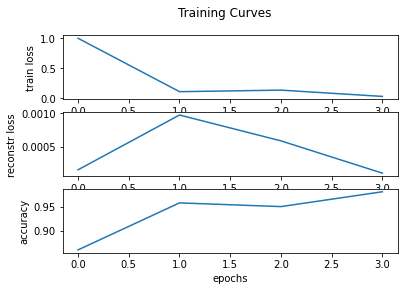

In [89]:
total_batches = 64*100
best_acc = 0
lamda = 8
batch_size = 128
learning_rate = 0.01 #0.001

optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate,betas=(0.9, 0.98),eps=1e-9)
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',factor=0.99,patience=50)

loss_all_list = []
rcloss_all_list = []
accuracy_list = []

for batch in range(total_batches):
    
    intro, introtarget, whatmyname, yournameis = teacher.get_batch(batch_size)
    
    out_vecs, trg_end, rcl, rcli = model.teacher_forcing(intro, introtarget)
    
    vocab_logits = model.vocab.emb2vocab(out_vecs)
    
    predictions = vocab_logits.view(-1, vocab_logits.size(-1))
    
    target = trg_end.view(-1)

    batch_loss = F.cross_entropy(predictions, target, 
                                 ignore_index = model.vocab.word2index["<PAD>"])

    reconstruction_loss = lamda*rcl
    
    ################# Next Part of Conversation ########################
    
    out_vecs, trg_end, rcl, rcli = model.teacher_forcing(whatmyname, yournameis)
    
    vocab_logits = model.vocab.emb2vocab(out_vecs)

    predictions = vocab_logits.view(-1, vocab_logits.size(-1))
    
    target = trg_end.view(-1)
    
    acc = accuracy_score(target, torch.argmax(predictions, dim=1))

    batch_loss += F.cross_entropy(predictions, target, 
                                 ignore_index = model.vocab.word2index["<PAD>"])
    
    reconstruction_loss += lamda*rcl
    conversation_loss = batch_loss + reconstruction_loss
    
    scheduler.step(conversation_loss)
    optimizer.zero_grad()
    conversation_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    
    if batch % int(total_batches/20 + 1) == 0:
        loss_all_list.append(conversation_loss.float().item())
        rcloss_all_list.append(reconstruction_loss.float().item())
        accuracy_list.append(acc)
        print("accuracy", round(acc,4), 
              "celoss", round(batch_loss.float().item(),4), 
              "rcloss", round(reconstruction_loss.float().item(),6), 
              "d_rcloss", round((rcli - rcl).float().item(),4),
              "training progress", round(batch/total_batches,4),
              "learning rate", scheduler._last_lr)
        if acc > best_acc:
            print('Saving Model...')
            best_acc = acc
            
            pickle.dump(model.vocab.word2index,open("modelstate/word2index.p","wb"))
            pickle.dump(model.vocab.index2word,open("modelstate/index2word.p","wb"))
            pickle.dump(model.vocab.emb2vocab.weight,open("modelstate/emb2vocab.weight.p","wb"))
            pickle.dump(model.vocab.embedding.weight,open("modelstate/embedding.weight.p","wb"))
            pickle.dump(model.context_vec,open("modelstate/context_vec.p","wb"))
            pickle.dump(model.mnm.memfunc.Ws,open("modelstate/Ws.p","wb"))
            save_model(model,"modelstate/task.pth")
            
        if acc > 0.97:
            break

fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle('Training Curves')
ax1.set(xlabel='epochs', ylabel='train loss')
ax2.set(xlabel='epochs', ylabel='reconstr loss')
ax3.set(xlabel='epochs', ylabel='accuracy')
ax1.plot(loss_all_list, label='train loss')
ax2.plot(rcloss_all_list, label='reconstrunction loss')
ax3.plot(accuracy_list, label='accuracy')

In [9]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

vocab.embedding.weight
vocab.emb2vocab.weight
encodeInput.layers.0.norm_1.alpha
encodeInput.layers.0.norm_1.bias
encodeInput.layers.0.norm_2.alpha
encodeInput.layers.0.norm_2.bias
encodeInput.layers.0.norm_3.alpha
encodeInput.layers.0.norm_3.bias
encodeInput.layers.0.attn_1.q_linear.weight
encodeInput.layers.0.attn_1.q_linear.bias
encodeInput.layers.0.attn_1.k_linear.weight
encodeInput.layers.0.attn_1.k_linear.bias
encodeInput.layers.0.attn_1.v_linear.weight
encodeInput.layers.0.attn_1.v_linear.bias
encodeInput.layers.0.attn_1.out.weight
encodeInput.layers.0.attn_1.out.bias
encodeInput.layers.0.attn_2.q_linear.weight
encodeInput.layers.0.attn_2.q_linear.bias
encodeInput.layers.0.attn_2.k_linear.weight
encodeInput.layers.0.attn_2.k_linear.bias
encodeInput.layers.0.attn_2.v_linear.weight
encodeInput.layers.0.attn_2.v_linear.bias
encodeInput.layers.0.attn_2.out.weight
encodeInput.layers.0.attn_2.out.bias
encodeInput.layers.0.ff.linear_1.weight
encodeInput.layers.0.ff.linear_1.bias
encodeI

In [5]:
model.vocab.emb2vocab.weight = pickle.load(open("modelstate/emb2vocab.weight.p","rb"))
model.vocab.embedding.weight = pickle.load(open("modelstate/embedding.weight.p","rb"))
model.vocab.word2index = pickle.load(open("modelstate/word2index.p","rb"))
model.vocab.index2word = pickle.load(open("modelstate/index2word.p","rb"))
load_model(model,"modelstate/task.pth")
model.mnm.memfunc.Ws = pickle.load(open("modelstate/Ws.p","rb"))
model.context_vec = pickle.load(open("modelstate/context_vec.p","rb"))
model

Bot(
  (vocab): Vocab(
    (embedding): Embedding(4, 32)
    (emb2vocab): Linear(in_features=32, out_features=4, bias=False)
  )
  (encodeInput): Transformer(
    (pe): PositionalEncoder(
      (dropout): Dropout(p=0.05, inplace=False)
    )
    (layers): ModuleList(
      (0): TransformerLayer(
        (norm_1): Norm()
        (norm_2): Norm()
        (norm_3): Norm()
        (dropout_1): Dropout(p=0.05, inplace=False)
        (dropout_2): Dropout(p=0.05, inplace=False)
        (dropout_3): Dropout(p=0.05, inplace=False)
        (attn_1): MultiHeadAttention(
          (q_linear): Linear(in_features=32, out_features=32, bias=True)
          (k_linear): Linear(in_features=32, out_features=32, bias=True)
          (v_linear): Linear(in_features=32, out_features=32, bias=True)
          (dropout): Dropout(p=0.05, inplace=False)
          (out): Linear(in_features=32, out_features=32, bias=True)
        )
        (attn_2): MultiHeadAttention(
          (q_linear): Linear(in_features=32, ou

In [6]:
for tell in [
             'my name is melissa', 'what is my name?', 
             'my name is vicki', 'what is my name?',
             'my name is zen', 'what is my name?',
             'my name is sky', 'what is my name?',
             ]:

    print(' > '+ tell)
    reply = model.string2string(tell)
    print(' > '+ reply)
    print(' ')

 > my name is melissa
 > hi melissa
 
 > what is my name?
 > its melissa
 
 > my name is vicki
 > hi vicki
 
 > what is my name?
 > its vicki
 
 > my name is zen
 > hi zen
 
 > what is my name?
 > its zen
 
 > my name is sky
 > hi sky
 
 > what is my name?
 > its sky
 
